# Standard Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

/tmp/ipykernel_851417/2124984718.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Constants
Listed below is the persistent seed I am choosing to use for this project along with some code to set it in all its instances. There is also some code for some standard column names that will be used many times in this project.

In [3]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

catechins = ['Catechin', 'Epicatechin', 'Gallocatechin', 'Epigallocatechin',
       'Catechin Gallate', 'Epicatechin Gallate', 'Gallocatechin Gallate',
       'Epigallocatechin Gallate']
chemicals = ['Catechin', 'Epicatechin', 'Gallocatechin', 'Epigallocatechin',
       'Catechin Gallate', 'Epicatechin Gallate', 'Gallocatechin Gallate',
       'Epigallocatechin Gallate', 'Caffeine']
sensory_evaluations = ['Taste','Appearance','Aroma','Liqour color','Infused leaf']

# Import data
This data is collected from a wide range of academic articles which bulk work consists of tea-catechins or sensory appeal.

In [4]:
# Chemical and Instrumental Assessment of Green Tea Sensory Preference - Y.R. Liang, Q. Ye, J. Jin, H. Liang, J.L. Lu, Y.Y. Du & J.J. Dong
# https://doi.org/10.1080/10942910701299430
# Notes: downloaded CSVs

df_10942910701299430 = pd.read_csv('../data/10942910701299430/chemical_composition.csv', header=1)
df_10942910701299430 = pd.concat([df_10942910701299430, pd.read_csv('../data/10942910701299430/sensory_evaluation.csv')], axis=1)

# Phytochemical Composition and Antioxidant Capacity of 30 Chinese Teas - by Guo-Yi Tang, Cai-Ning Zhao, Xiao-Yu Xu, Ren-You Gan, Shi-Yu Cao, Qing Liu, AoShang, Qian-Qian Mao & Hua-Bin Li
# https://doi.org/10.3390/antiox8060180
# Notes: Manually scraped data

df_antiox8060180 = pd.read_csv('../data/antiox8060180/chemical_composition.csv')

# Catechin and caffeine content of tea (Camellia sinensis L.) leaf significantly differ with seasonal variation... - Himangshu Deka, Tupu Barman, Jintu Dutta, Arundhuti Devi, Pradip Tamuly, Ranjit Kumar Paul & Tanmoy Karak 
# https://doi.org/10.1016/j.jfca.2020.103684
# https://krishi.icar.gov.in/jspui/bitstream/123456789/68751/2/S0889157520313892-main.pdf - Free access

# df_j.jfca.2020.103684_chemical_composition = pd.read_csv('dava/j.jfca.2020.103684/chemical_composition.csv')

# Comparative analysis of tea catechins and theaflavins by high-performance liquid chromatography and capillary electrophoresis - Bee-Lan Lee & Choon-Nam Ong
# https://doi.org/10.1016/S0021-9673(00)00215-6
# Notes: Manually scraped data

df_S0021967300002156 = pd.read_csv('../data/S0021967300002156/chemical_composition.csv')

# Survey of Catechins, Gallic Acid, and Methylxanthines in Green, Oolong, Pu-erh, and Black Teas - Jen-Kun Lin, Chih-Li Lin, Yu-Chih Liang, Shoei-Yn Lin-Shiau & I-Ming Juan
# https://doi.org/10.1021/jf980223x
# Notes: Manually scraped data

df_jf980223x = pd.read_csv('../data/jf980223x/chemical_composition.csv')

# Analysis of some selected catechins and caffeine in green tea by high performance liquid chromatography
# https://doi.org/10.1016/j.foodchem.2012.03.039
# Notes: Manually scraped data

df_jfoodchem201203039 = pd.read_csv('../data/jfoodchem201203039/chemical_composition.csv', on_bad_lines='skip')

# Catechin content of 18 teas and a green tea extract supplement correlates with the antioxidant capacity 
# https://doi.org/10.1207/S15327914NC4502_13
# Notes: Manually scraped data

df_15327914NC4502_13 = pd.read_csv('../data/15327914NC4502_13/chemical_composition.csv')

# Catechin contents in tea (Camellia sinensis) as affected by cultivar and environment and their relation to chlorophyll contents
# https://doi.org/10.1016/j.foodchem.2010.08.029
# Notes: Manually scraped data

df_jfoodchem201008029 = pd.read_csv('../data/jfoodchem201008029/chemical_composition.csv')

# Analysis of Catechin Content of Commercial Green Tea Products
# https://doi.org/10.1080/J157v03n03_03
# Notes: Manually scraped data

df_J157v03n03_03 = pd.read_csv('../data/J157v03n03_03/chemical_composition.csv')

# Phenol-Explorer database scraping
# phenol-explorer.eu
# Notes: Manually scraped data

df_phenol_explorer = pd.read_csv('../data/phenol_explorer/chemical_composition.csv')

In [5]:
# List of all imported dataframes
all_dataframes = [df_10942910701299430,
                  df_antiox8060180,
                  df_S0021967300002156,
                  df_jf980223x,
                  df_jfoodchem201203039,
                  df_15327914NC4502_13,
                  df_phenol_explorer]

# Combine data

To combine the data I am going to create a data pipeline that does the following:

1. Add all the pandas dataframes to a list.
2. Read that list into a function.
3. The function reads an individual dataframe from that list then resets the index, rename catechins to be like the catechin dictionary below, drop unused columns, add columns that are part of the standardized column format, and then sorts the columns to be part of the standardized column format.
4. The function will then add the dataframe to a list denoting it is processed.
5. Once the function has processed all the dataframes in the lists it will loop through the data frames in the finished list and concatenate them.
6. The function will return a combined dataframe.

## Data Frame Format

The data frames will be combined into the following format:

- `'Catechin'`
- `'Epicatechin'`
- `'Gallocatechin'`
- `'Epigallocatechin'`
- `'Catechin Gallate'`
- `'Epicatechin Gallate'`
- `'Gallocatechin Gallate'`
- `'Epigallocatechin Gallate'`
- `'Gallic Acid'`
- `'Chlorogenic Acid'`
- `'Caffeine'`
- `'Taste'`
- `'Appearance'`
- `'Aroma'`
- `'Liqour color'`


In [6]:
catechin_dictionary = {
    'C': 'Catechin',
    'EC': 'Epicatechin',
    'GC': 'Gallocatechin',
    'EGC': 'Epigallocatechin',
    'CG': 'Catechin Gallate',
    'ECG': 'Epicatechin Gallate',
    'GCG': 'Gallocatechin Gallate',
    'EGCG': 'Epigallocatechin Gallate'
}

standardized_columns = [
    'Catechin',
    'Epicatechin',
    'Gallocatechin',
    'Epigallocatechin',
    'Catechin Gallate',
    'Epicatechin Gallate',
    'Gallocatechin Gallate',
    'Epigallocatechin Gallate',
    'Caffeine',
    'Taste',
    'Appearance',
    'Aroma',
    'Liqour color',
    'Infused leaf'
]

To faciliate scability I am create a sklearn pipeline and process all my data to be concatenated.
First I will define the functions that will go into my data preprocessing pipeline.

In [7]:
def reset_index(dataframe: pd.DataFrame):
    return dataframe.reset_index(drop=1)

def rename_columns(dataframe: pd.DataFrame):
    return dataframe.rename(columns=catechin_dictionary)

def drop_nonstandardized_columns(dataframe: pd.DataFrame):
    return dataframe.drop(columns=[column for column in dataframe if column not in standardized_columns])

def reformat_columns(dataframe: pd.DataFrame):
    return dataframe.reindex(columns=standardized_columns)

def remove_standard_deviation_format(dataframe: pd.DataFrame):
    for column in dataframe.columns:
        if (dataframe[column].dtype.name == 'object') or (dataframe[column].dtype.name == 'string'):
            dataframe[column] = dataframe[column].str.replace('± \d*.\d*', '', regex=True)
    return dataframe    

Next, the data pipeline applies all of those functions to the inputed dataset.

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

ResetIndexTransformer = FunctionTransformer(reset_index)
RenameColumnsTransformer = FunctionTransformer(rename_columns)
DropNonstandardizedColumnsTransformer = FunctionTransformer(drop_nonstandardized_columns)
ReformatColumnsTransformer = FunctionTransformer(reformat_columns)
RemoveStandardDeviationFormat = FunctionTransformer(remove_standard_deviation_format)

data_combining_pipeline = make_pipeline(
    ResetIndexTransformer,
    RenameColumnsTransformer,
    DropNonstandardizedColumnsTransformer,
    ReformatColumnsTransformer,
    RemoveStandardDeviationFormat
)

Now I am creating a pipeline that transforms each dataframe then concatenates it and returns one dataframe to be used for the model.

In [9]:
def process_dataframes(dataframes: list):
    processed_dataframes = []
    for dataframe in dataframes:
        dataframe = data_combining_pipeline.fit_transform(dataframe)
        processed_dataframes.append(dataframe)
    return processed_dataframes

def concatenate_dataframes(dataframes: list):
    formated_dataframe = pd.concat(dataframes, ignore_index=True)
    return formated_dataframe

def change_dtypes(dataframe: pd.DataFrame):
    for column in dataframe.columns:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
    return dataframe

In [10]:
ProcessDataframes = FunctionTransformer(process_dataframes)
ConcatenateDataframes = FunctionTransformer(concatenate_dataframes)
Change_Dtypes = FunctionTransformer(change_dtypes)

data_combining_pipeline_processor = make_pipeline(
    ProcessDataframes,
    ConcatenateDataframes,
    Change_Dtypes
)

In [11]:
df = data_combining_pipeline_processor.transform(all_dataframes)
df.head()

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,8.93,7.04,8.36,18.00,3.72,4.66,21.50,21.11,31.47,23.1,7.9,23.1,8.1,15.2
1,9.87,NaN,22.55,10.92,5.33,5.29,26.62,23.42,39.24,25.8,8.1,24.9,8.3,16.4
2,6.37,4.92,21.87,10.98,5.29,5.43,24.84,23.63,41.08,23.7,7.8,23.7,7.6,15.8
3,6.78,5.91,23.08,11.47,5.76,6.43,25.34,22.14,50.97,23.7,8.3,24.0,8.6,16.6
4,5.82,5.60,24.12,13.35,5.28,5.94,27.92,25.09,53.70,24.6,8.2,26.4,8.5,16.6


# Remove Extraneous Data
It is common for this aggregated dataset to come with columns that contain no data at all, that will be removed here.

In [12]:
df = df.dropna(how='all', axis=0)

# Data Explanation

The data we will be examining and training on is purely numerical. This has many advantages in terms of cleaning and training but a few disadvantages that may not be readily appearant. The catechins and caffeine are all listed in milligrams. What is taste, appearance, aroma, and liquor color measured in? Milligrams? No, instead it is much more complicated. Thankfully this is a pretty standardized tea tasting scoring system throughout China so most of our data will reflect that, any data that does not reflect that will be modified into this scoring system. The scoring system is outlined below:


    Scoring System: They used a scoring system where the highest possible score for a tea sample was 100. This score was divided into different categories, each representing a different aspect of the tea:
        Dry Tea Appearance (10% of the total score): This is about how the tea leaves look when they are dry. The experts looked at the color, size, how tender the leaves were, and how evenly the leaves were twisted.
        Aroma (30% of the total score): This is about how the tea smells.
        Liquor Color (10% of the total score): This is about the color of the tea when it's steeped in water.
        Taste (30% of the total score): This is, of course, about how the tea tastes.
        Infused Leaf (20% of the total score): After the tea has been steeped, the experts looked at the leaves again to see their color, size, tenderness, and evenness.

    How They Tested:
        Dry Tea Appearance: They placed 200 grams of dry tea on a wooden tray (20 cm x 20 cm) and scored it based on the criteria mentioned above.
        Preparing the Tea: For testing aroma, liquor color, and taste, they steeped 3 grams of the tea in 150 milliliters of boiling water for 5 minutes.
        Tasting and Scoring: The tea was then poured into a special tasting bowl. The experts compared the aroma, color, and taste of the tea to three reference samples they had in their lab to give their scores.
        Infused Leaf: Finally, they put the steeped leaves into a porcelain tray with cold water and scored them based on color, size, tenderness, and evenness.



# Exploratory Data Analysis

This pairplot offers a high-level visualization of what is going on internally in the dataset. Next, we will examine further the intricacies of the data before cleaning it further and imputing data using a Generative Adversarial Network.

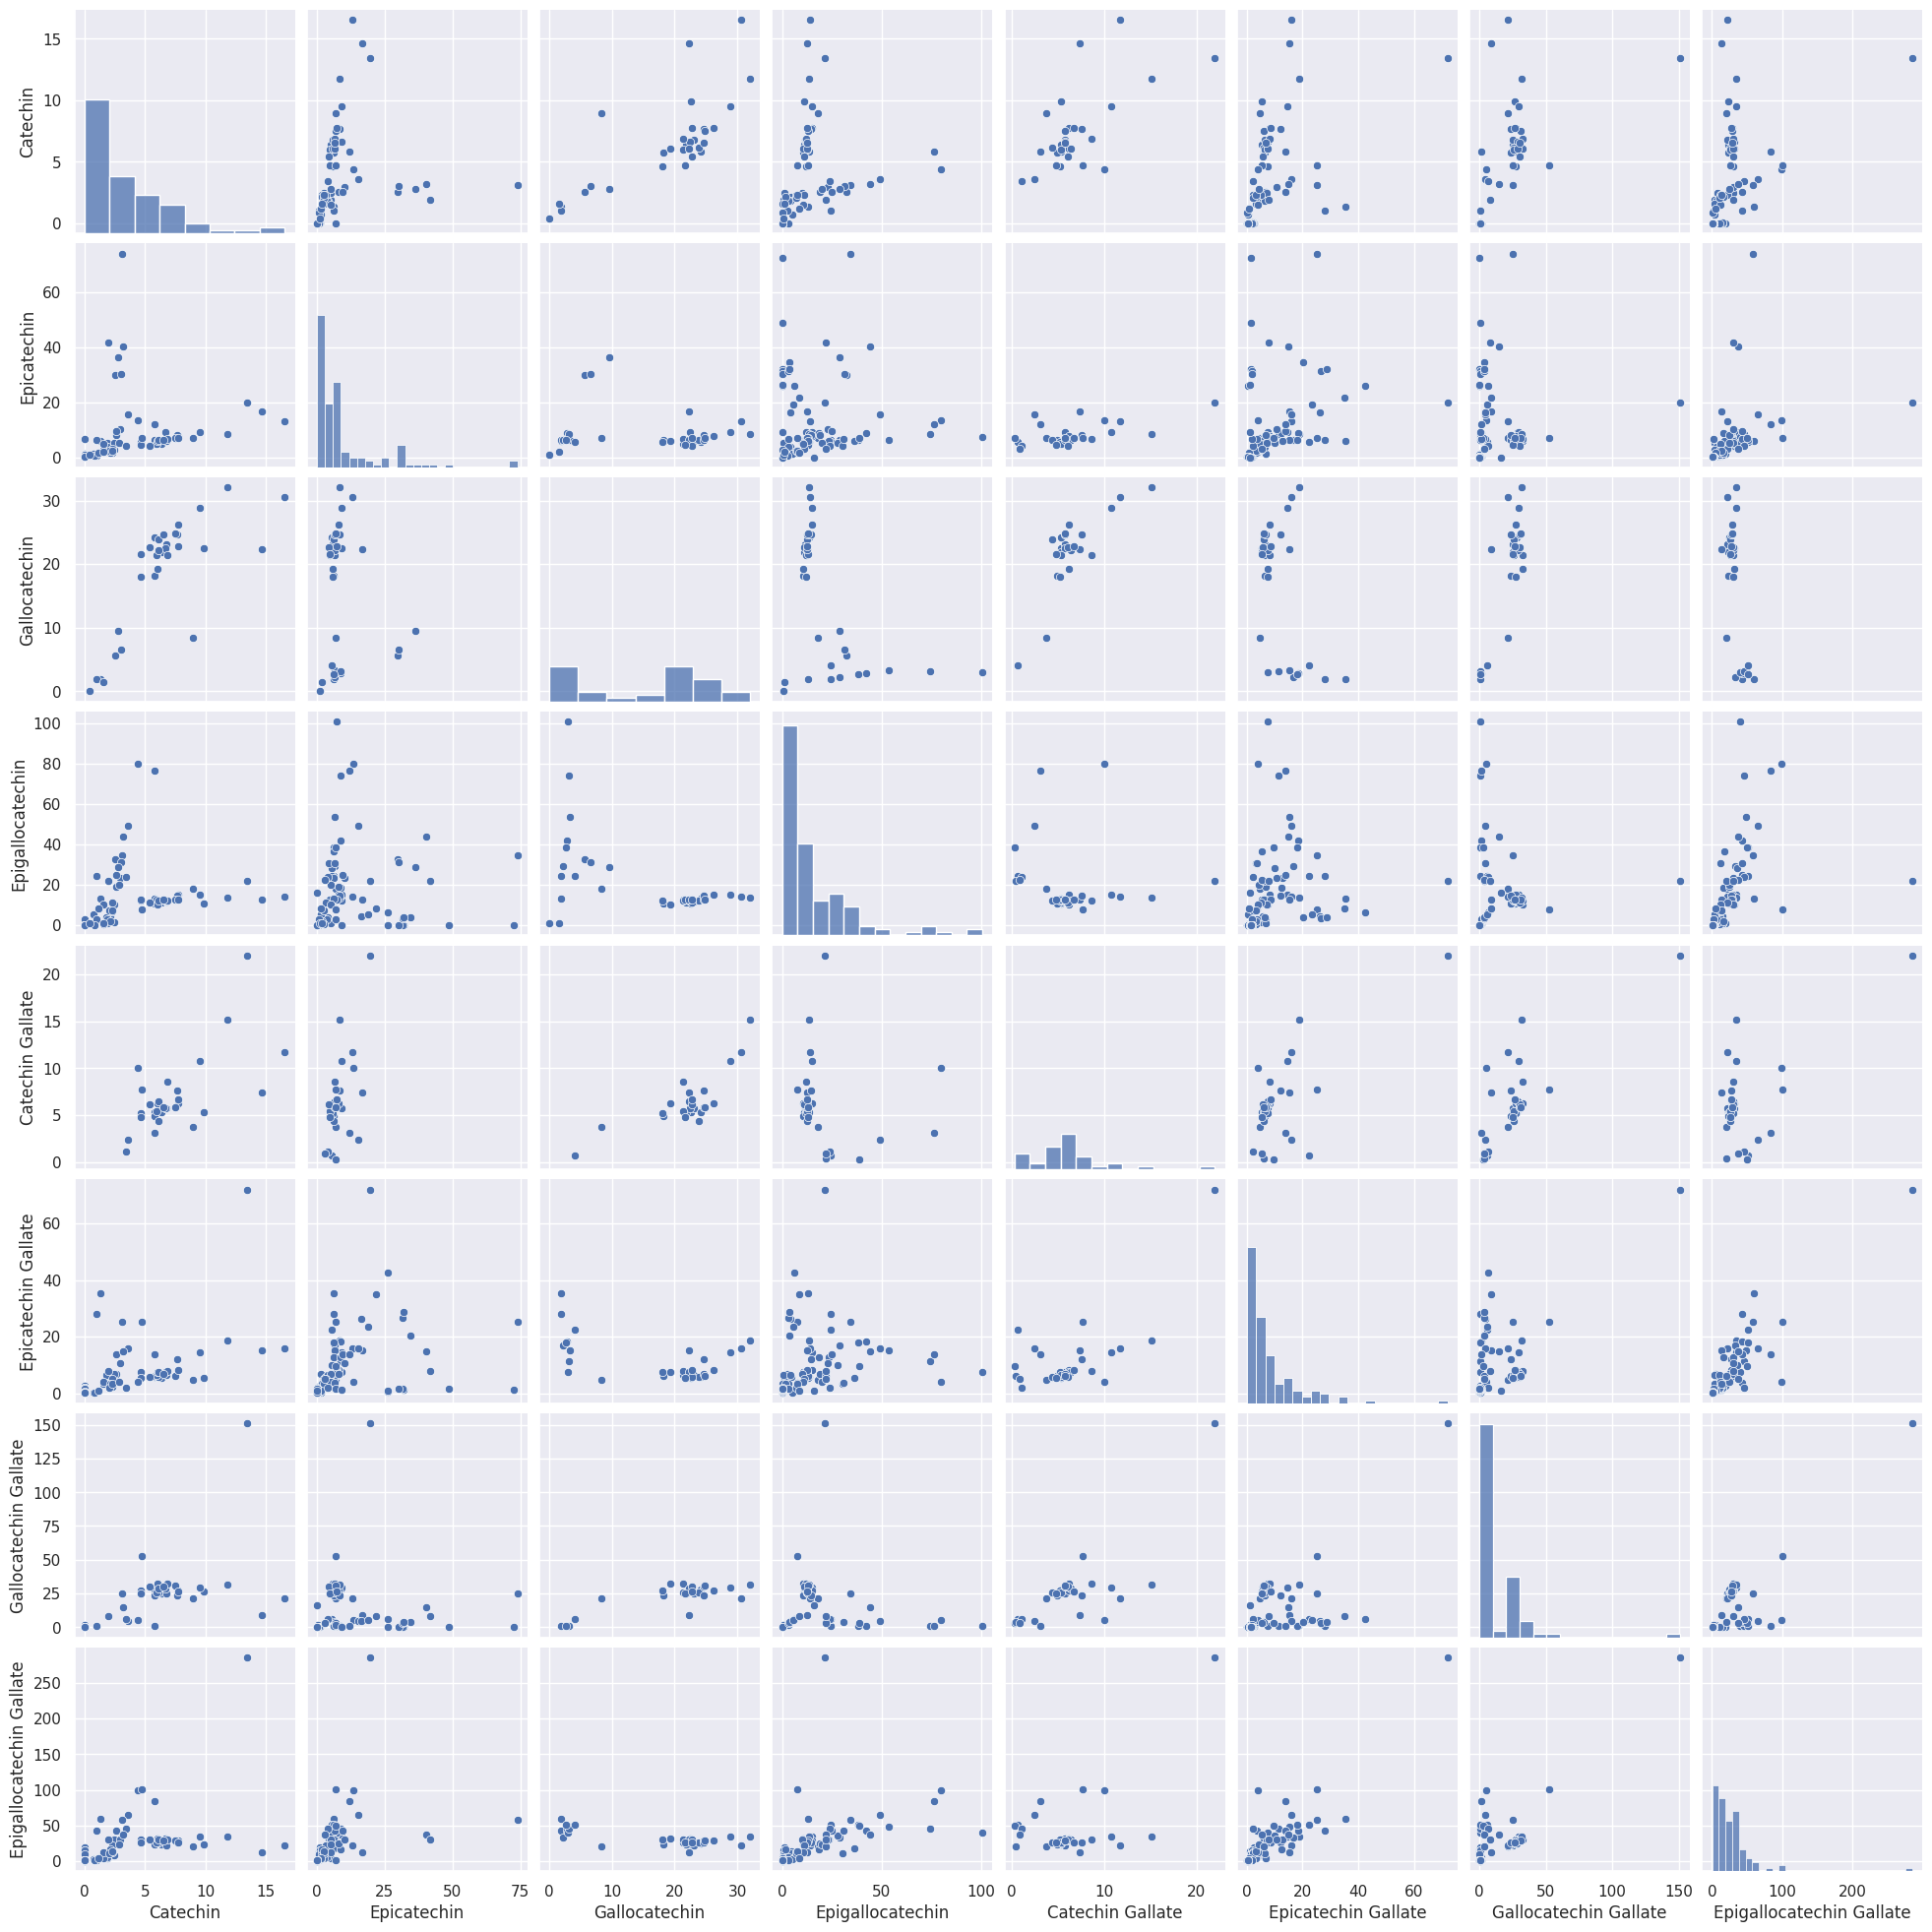

In [13]:
sns.set_theme()
sns.pairplot(df[catechins])

# Summary Statistics

The summary statistics of the agggregated data is displayed below. It is interesting to note that there are some significant outliers. One such outlier is Epigallocatechin with a max of aroun 100mg.

In [14]:
df.describe()

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
count,88.000000,126.000000,38.000000,140.000000,34.000000,122.000000,96.000000,103.000000,77.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,3.224205,9.201770,15.676895,15.351629,6.136618,8.033852,11.115458,25.658369,22.670130,24.275000,7.937500,24.545833,8.241667,16.433333
std,3.625484,13.214851,10.256015,19.894685,4.274245,10.327908,19.198973,32.623663,20.182393,1.506291,0.436201,1.601352,0.461488,0.856010
min,0.001000,0.000000,0.000000,0.010000,0.300000,0.070000,0.100000,0.300000,0.558000,22.200000,6.800000,22.200000,7.300000,14.800000
25%,0.020000,1.020000,3.458250,0.837750,4.445000,1.610000,0.260000,8.380000,1.970000,23.325000,7.800000,23.325000,7.950000,15.800000
50%,2.220000,5.325000,21.380000,10.420000,5.755000,5.090000,3.400000,21.110000,16.300000,23.850000,7.950000,24.400000,8.300000,16.400000
75%,5.777500,8.672500,23.017500,22.450000,7.195000,9.852500,23.290000,31.005000,41.080000,25.275000,8.125000,25.875000,8.525000,16.900000
max,16.540000,73.890000,32.020000,100.684000,22.000000,72.000000,150.900000,285.100000,58.830000,27.600000,8.800000,27.600000,8.900000,17.800000


# Training Device

As I am developing on Linux and training on Windows, this code displays if CUDA functionality is being used or not.

In [15]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Split data

For this model we will not be using a validation set because of the limited nature of the data.

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)

# Data Imputation and Scaling

The data imputation for this aggregated dataset will be done in two parts:

1. **Chemicals Imputation**:
   - The chemicals will be imputed using sklearn's `SimpleImputer`.

2. **Min-Max Scaler**:
   - A min-max scaler will be applied so the GAN can learn features correctly.

3. **Sensory Appeals Generation**:
   - The sensory appeals will be generated by a custom `Generative Adversarial Network (GAN)`.


### Missing Chemical Imputation with an Iterative Imputer
Note this is causing some negative values that need to be fixed, possibly rows with complete missing data is causing this.

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=100, verbose=2, random_state=42, imputation_order='random', min_value=[0.02, 1.02, 3.46, 0.84, 4.45, 1.61, 0.26, 8.38, 1.97]) # 25th percentile rounded, may change

train_df[chemicals] = imputer.fit_transform(train_df[chemicals])
test_df[chemicals] = imputer.transform(test_df[chemicals])

test_df

[IterativeImputer] Completing matrix with shape (116, 9)
[IterativeImputer] Ending imputation round 1/100, elapsed time 0.01
[IterativeImputer] Change: 81.40064712552831, scaled tolerance: 0.100684 
[IterativeImputer] Ending imputation round 2/100, elapsed time 0.02
[IterativeImputer] Change: 28.491577138549104, scaled tolerance: 0.100684 
[IterativeImputer] Ending imputation round 3/100, elapsed time 0.02
[IterativeImputer] Change: 15.496270059340068, scaled tolerance: 0.100684 
[IterativeImputer] Ending imputation round 4/100, elapsed time 0.03
[IterativeImputer] Change: 13.127900795782958, scaled tolerance: 0.100684 
[IterativeImputer] Ending imputation round 5/100, elapsed time 0.04
[IterativeImputer] Change: 12.732544527051347, scaled tolerance: 0.100684 
[IterativeImputer] Ending imputation round 6/100, elapsed time 0.04
[IterativeImputer] Change: 12.632513428954812, scaled tolerance: 0.100684 
[IterativeImputer] Ending imputation round 7/100, elapsed time 0.05
[IterativeImputer]

/home/tahlon/Documents/Projects/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
71,2.580000,9.500000,3.460000,24.900000,4.450000,13.900000,2.040958,43.300000,1.970000,NaN,NaN,NaN,NaN,NaN
142,2.570000,29.700000,5.580000,32.600000,4.450000,17.995345,0.260000,50.490500,25.523248,NaN,NaN,NaN,NaN,NaN
28,2.627925,6.443000,2.135000,29.070000,4.450000,16.774000,0.260000,33.102000,34.706000,NaN,NaN,NaN,NaN,NaN
19,16.540000,12.900000,30.550000,14.290000,11.710000,15.970000,21.430000,22.440000,54.110000,23.7,7.9,24.9,8.3,15.8
44,0.020000,0.570000,3.460000,0.720000,4.450000,1.230000,0.220000,13.610000,6.990000,NaN,NaN,NaN,NaN,NaN
119,0.020000,16.200000,3.460000,4.400000,4.608164,26.200000,4.400000,50.399199,18.277114,NaN,NaN,NaN,NaN,NaN
128,4.057653,1.020000,3.460000,24.486356,4.450000,11.369755,8.000000,37.156434,15.608702,NaN,NaN,NaN,NaN,NaN
110,0.020000,48.750000,20.502896,0.010000,4.450000,1.610000,0.240000,9.300359,34.864724,NaN,NaN,NaN,NaN,NaN
86,13.400000,19.700000,37.636695,21.700000,22.000000,72.000000,150.900000,285.100000,16.300000,NaN,NaN,NaN,NaN,NaN
18,11.770000,8.480000,32.020000,13.450000,15.150000,18.720000,31.710000,34.360000,56.710000,27.0,8.0,26.7,8.9,17.6


# Generation of Additional Data

In [18]:
from sklearn.neighbors import KNeighborsRegressor




# Feature Scaling
The data is purely numerical, therefore the data will be only normalized. 

In [19]:
# Normalization: Min-Max Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # Note: I am still not sure if I want to scale the labels.

scaled_train_df = scaler.fit_transform(train_df)
scaled_test_df = scaler.transform(test_df)

scaled_train_df = pd.DataFrame(scaled_train_df, columns=standardized_columns)
scaled_test_df = pd.DataFrame(scaled_test_df, columns=standardized_columns)

In [20]:
scaled_train_df

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,0.311760,0.007305,0.043969,0.118998,0.035822,0.032244,0.519734,0.295110,0.049794,0.000000,0.50,0.055556,0.4375,0.533333
1,0.393607,0.007228,0.058951,0.132507,0.036648,0.025892,0.527894,0.247405,0.057685,0.444444,0.70,0.777778,0.7500,0.600000
2,0.295179,0.011229,0.006878,0.417715,0.030415,0.081041,0.019677,0.426707,0.038671,NaN,NaN,NaN,NaN,NaN
3,0.001285,0.041301,0.026861,0.036653,0.048218,0.126725,0.068311,0.470779,0.036714,NaN,NaN,NaN,NaN,NaN
4,0.223299,0.002617,0.008456,0.203382,0.030415,0.041094,0.092979,0.296046,0.014359,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.154155,0.003046,0.008456,0.074597,0.030415,0.014468,0.012100,0.135729,0.001121,NaN,NaN,NaN,NaN,NaN
112,0.001285,0.011809,0.013656,0.000099,0.030415,0.004808,0.002846,0.080639,0.007825,NaN,NaN,NaN,NaN,NaN
113,0.410517,0.008299,0.054356,0.123071,0.045209,0.033258,0.537381,0.298004,0.050088,1.000000,0.85,1.000000,1.0000,0.866667
114,0.000068,0.000039,0.011081,0.000099,0.030415,0.000838,0.003036,0.009182,0.008695,NaN,NaN,NaN,NaN,NaN


# Generative Adversarial Network

The purpose of the GAN is to impute missing sensory values. A GAN is a combination of two neural networks: a generator and a discriminator. The generator will generate numbers that it thinks are the appropiate sensory evaluations based on the givens catechins and caffeine input. The discriminator will then decide if that is a realistic output or not. In the end, all missing data on sensory evaluations will be naturally imputted. Much of this was interpreted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html although specifically using GAN not DCGAN.

In [21]:
# Create a training dataset for the GAN (rows that include all sensory scores)
GAN_train_df = scaled_train_df[(scaled_train_df[sensory_evaluations] > 0).all(axis=1)].dropna(axis=0) # Subset of data containing complete sensory evaluations, right now the GAN does not perform well because of lack of data
GAN_test_df = scaled_test_df[(scaled_test_df[sensory_evaluations] > 0).all(axis=1)].dropna(axis=0) 

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input Layer
            nn.Linear(9, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 5),
            nn.Sigmoid() # This is used because output values are in the range [0, 1) (after scaling of course).
        )


    def forward(self, input):
        output = self.main(input)
        return output

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input layer
            nn.Linear(14, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Dropout to prevent overfitting

            # Hidden layer
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Output layer - single neuron for binary classification (real or fake)
            nn.Linear(32, 1),
            nn.Sigmoid()  # Sigmoid to output a probability
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1) # Outputs 1D tensor of probabilities 


You must create a custom torch dataset for it to go into the torch dataloader.

In [24]:
# Custom GAN Dataset
from torch.utils.data import Dataset

class GANDataset(Dataset):
    def __init__(self, dataframe):
        self.data_frame = dataframe

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data_frame.iloc[idx]
        sample = torch.tensor(sample.values, dtype=torch.float32)
        return sample

GAN_dataset = GANDataset(GAN_train_df)

In [25]:
# GAN Dataloader 
from torch.utils.data import DataLoader
dataloader = DataLoader(GAN_dataset, batch_size=32, shuffle=True)

In [26]:
# Model Creation
generator = Generator().to(device)
discriminator = Discriminator().to(device)

Optimally, I would like to make all of this a reusable pytorch class. There is no hyperparameter searching like grid-search cv in pytorch so I had to do it manually.

In [27]:
# Setup Adam optimizers for both G and D
import torch.optim as optim
optimizerD = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))  
optimizerG = optim.Adam(generator.parameters(), lr=0.0008, betas=(0.5, 0.999))

# Initialize the BCELoss function
criterion = nn.BCELoss()

generator_losses = []
discriminator_losses = []
epochs = 200

def train_GAN():
    for epoch in range(epochs):
        for i, data in enumerate(dataloader, 0):
            
            # Seperate data and convert to current device
            chemical_data = data[:, :9] # Features seperated
            sensory_data = data[:, 9:] # Labels seperated

            chemical_data = chemical_data.to(device)
            sensory_data = sensory_data.to(device)

            # Find current batch size
            current_batch_size = chemical_data.size(0)

            # Create labels for real and generated data
            real_label = torch.full((current_batch_size,), .9, dtype=torch.float, device=device) # Creates a tensor of labels indiciated data is real w/ label smoothing
            fake_label = torch.full((current_batch_size,), 0. , dtype=torch.float, device=device) # Creates a tensor of labels indidicated data is generated

            # Update Discriminator - Clear accumulated gradients from previous pass
            discriminator.zero_grad()

            # Train discriminator with real data w/ some notes for myself
            real_data = torch.cat((chemical_data, sensory_data), 1) # Same as pd.concat(axis=1)
            output = discriminator(real_data).view(-1) # Same as numpy.reshape(-1,1), used to calculate loss
            errD_real = criterion(output, real_label)
            errD_real.backward() # Perform backpropogation based on errD_real
            D_x = output.mean().item() # Outputs average discriminator prediction

            # Train discriminator with fake data
            fake_sensory_data = generator(chemical_data) 
            fake_data = torch.cat((chemical_data, fake_sensory_data), 1) # Create a dataset of real chemical data but generated sensory data
            output = discriminator(fake_data.detach()).view(-1) # detach is used to ensure gradients aren't computed for the generator during the discriminators backwards pass
            errD_fake = criterion(output, fake_label)
            errD_fake.backward()
            D_G_z1 = output.mean().item() # Outputs average discriminator prediction for fake data

            # Update Discriminator weights
            errD = errD_real + errD_fake
            optimizerD.step()

            # Update Generator
            generator.zero_grad()
            output = discriminator(fake_data).view(-1)
            errG = criterion(output, real_label)
            errG.backward()
            D_G_z2 = output.mean().item()

            # Update Generate weights
            optimizerG.step()

            # Print training log
            if i % 50 == 0: # Prints every 50 batches, might change
                print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}] '
                    f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                    f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
                
            # Save losses
            generator_losses.append(errG.item())
            discriminator_losses.append(errD.item())

train_GAN()

[0/200][0/1] Loss_D: 1.3900 Loss_G: 0.7009 D(x): 0.4907 D(G(z)): 0.4940 / 0.4953
[1/200][0/1] Loss_D: 1.3909 Loss_G: 0.7254 D(x): 0.4847 D(G(z)): 0.4894 / 0.4805
[2/200][0/1] Loss_D: 1.3903 Loss_G: 0.7155 D(x): 0.4894 D(G(z)): 0.4930 / 0.4864
[3/200][0/1] Loss_D: 1.3836 Loss_G: 0.7116 D(x): 0.4892 D(G(z)): 0.4896 / 0.4888
[4/200][0/1] Loss_D: 1.3930 Loss_G: 0.7175 D(x): 0.4830 D(G(z)): 0.4891 / 0.4852
[5/200][0/1] Loss_D: 1.3785 Loss_G: 0.7226 D(x): 0.4884 D(G(z)): 0.4863 / 0.4822
[6/200][0/1] Loss_D: 1.3902 Loss_G: 0.7124 D(x): 0.4783 D(G(z)): 0.4837 / 0.4883
[7/200][0/1] Loss_D: 1.3914 Loss_G: 0.7161 D(x): 0.4806 D(G(z)): 0.4861 / 0.4860
[8/200][0/1] Loss_D: 1.3878 Loss_G: 0.7186 D(x): 0.4829 D(G(z)): 0.4864 / 0.4846
[9/200][0/1] Loss_D: 1.3664 Loss_G: 0.7234 D(x): 0.4878 D(G(z)): 0.4795 / 0.4818
[10/200][0/1] Loss_D: 1.3795 Loss_G: 0.7248 D(x): 0.4834 D(G(z)): 0.4826 / 0.4809
[11/200][0/1] Loss_D: 1.3832 Loss_G: 0.7261 D(x): 0.4803 D(G(z)): 0.4818 / 0.4801
[12/200][0/1] Loss_D: 1.38

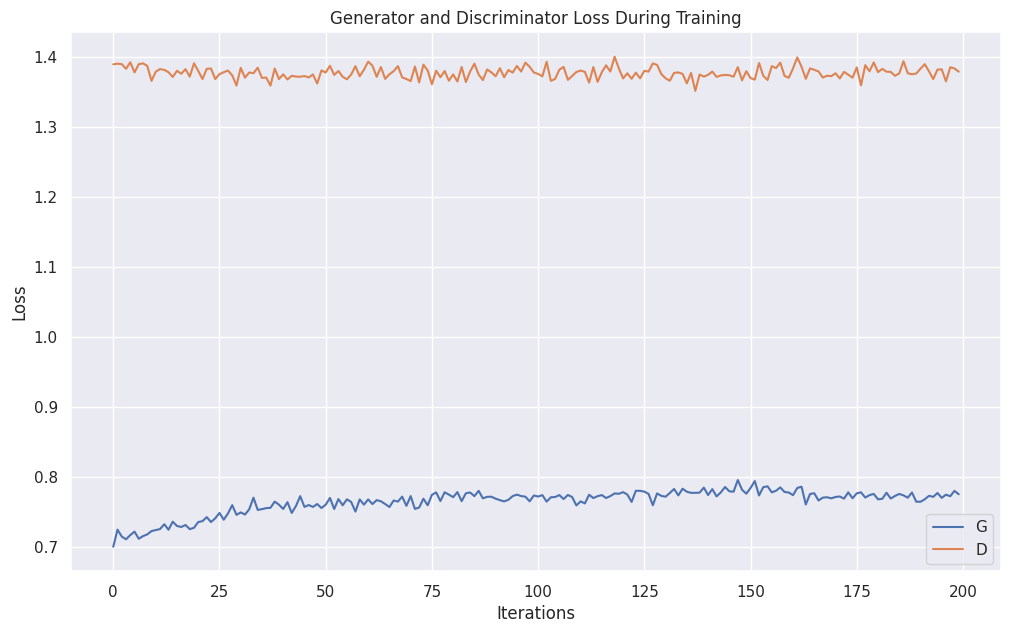

In [28]:
def plot_GAN_loss():
    plt.figure(figsize=(12,7))
    plt.title('Generator and Discriminator Loss During Training')
    plt.plot(generator_losses, label='G')
    plt.plot(discriminator_losses, label='D')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

plot_GAN_loss()

# Define rows that need to be imputed
These are the rows currently missing sensory data

In [29]:
train_data_to_impute = torch.tensor(scaled_train_df[(scaled_train_df[sensory_evaluations].isna()).all(axis=1)][chemicals].values, dtype=torch.float32).to(device)
test_data_to_impute = torch.tensor(scaled_test_df[(scaled_test_df[sensory_evaluations].isna()).all(axis=1)][chemicals].values, dtype=torch.float32).to(device)

# Impute missing sensory data with the GAN

In [30]:
generator.eval() # Put generator in eval mode

with torch.no_grad():
    imputed_sensory_data_train = pd.DataFrame(generator(train_data_to_impute).cpu().numpy(), columns=sensory_evaluations)
    imputed_sensory_data_test = pd.DataFrame(generator(test_data_to_impute).cpu().numpy(), columns=sensory_evaluations)

In [31]:
pd.DataFrame(test_data_to_impute.cpu(), columns=chemicals)

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine
0,0.174448,0.012261,0.008456,0.247234,0.030415,0.061003,0.036830,0.429142,0.001382
1,0.173771,0.038332,0.013638,0.323718,0.030415,0.079067,0.003036,0.500903,0.027017
2,0.177689,0.008316,0.005218,0.288654,0.030415,0.073680,0.003036,0.327365,0.037012
3,0.001285,0.000736,0.008456,0.007052,0.030415,0.005117,0.002277,0.132834,0.006846
4,0.001285,0.020908,0.008456,0.043606,0.031603,0.115257,0.081594,0.499992,0.019131
5,0.274399,0.001316,0.008456,0.243125,0.030415,0.049842,0.149905,0.367829,0.016227
6,0.001285,0.062919,0.050110,0.000000,0.030415,0.006793,0.002657,0.089824,0.037185
7,0.906330,0.025426,0.091987,0.215448,0.162212,0.317276,2.861480,2.842315,0.016979
8,0.128451,0.006556,0.011753,0.008612,0.030415,0.028935,0.003036,0.037425,0.000805
9,0.271375,0.011672,0.008456,0.352127,0.030415,0.047652,0.003036,0.346369,0.021312


# Concatenate imputed values to host dataframe

In [32]:
imputed_train_df = pd.concat([pd.DataFrame(train_data_to_impute.cpu()), pd.DataFrame(imputed_sensory_data_train)], axis=1).set_axis(standardized_columns, axis='columns')
imputed_test_df = pd.concat([pd.DataFrame(test_data_to_impute.cpu()), pd.DataFrame(imputed_sensory_data_test)], axis=1).set_axis(standardized_columns, axis='columns')

train_df = pd.concat([GAN_train_df, imputed_train_df], axis=0)
test_df = pd.concat([GAN_test_df, imputed_test_df], axis=0)

# Feature Engineering

A derived feature called overall score will be produced from all sensory scores so the models only have to predict a single response.

In [33]:
# Derived Feature: Overall Sensory Score
def compute_sensory_score(df):
    df['Overall Sensory Score'] = df['Taste'] + df['Appearance'] + df['Aroma'] + df['Liqour color'] + df['Infused leaf']
    df = df.drop(columns=['Taste','Appearance','Aroma','Liqour color','Infused leaf'])
    return df

train_df = compute_sensory_score(train_df)
test_df = compute_sensory_score(test_df)


# PCA (Principal Component Analysis)

Because the high-dimensional nature of the data, PCA will be used to reduce the number of features.

In [34]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=9, random_state=42)

train_X = kpca.fit_transform(train_df.drop(columns=['Overall Sensory Score']))
test_X = kpca.transform(test_df.drop(columns=['Overall Sensory Score']))

train_y = train_df[['Overall Sensory Score']]
test_y = test_df[['Overall Sensory Score']]

# https://stackoverflow.com/questions/29611842/scikit-learn-kernel-pca-explained-variancepca.explained_variance_
explained_variance = np.var(train_X, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
exp_var_cumul = np.cumsum(explained_variance_ratio)

In [35]:
# Prepare data for Torch-based models
train_X_tensor = torch.tensor(train_X, dtype=torch.float64).float()
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float64).float()
test_X_tensor = torch.tensor(test_X, dtype=torch.float64).float()

In [36]:
import plotly.express as px

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

The explained variance ratio achieved with just 2 components is sufficiently high, making it suitable for visualization in a 3D space. Therefore, I will proceed by focusing on these 2 components for my model training.

In [37]:
# Extract first two components
train_X = train_X[:, :2]
test_X = test_X[:, :2]

# Prepare data for Torch-based models
train_X_tensor = torch.tensor(train_X, dtype=torch.float64).float()
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float64).float()
test_X_tensor = torch.tensor(test_X, dtype=torch.float64).float()

# Random Forest

Pytorch does not have a built in Random Forest class, instead we will use scikit learn's implementation. 

In [38]:
# Model Creation
from sklearn.ensemble import RandomForestRegressor

GridSearchCV_random_forest = RandomForestRegressor()

In [39]:
# Hyperparameter Selection
from sklearn.model_selection import GridSearchCV

parameters_random_forest = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_depth': [int(x) for x in np.linspace(start=1, stop=6, num=6)],
    'min_samples_split': [int(x) for x in np.linspace(start=1, stop=6, num=6)],
    'random_state': [42]
}

clf_random_forest = GridSearchCV(GridSearchCV_random_forest, parameters_random_forest)
clf_random_forest.fit(train_X, train_y.values.ravel())

/home/tahlon/Documents/Projects/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


300 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tahlon/Documents/Projects/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tahlon/Documents/Projects/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/tahlon/Documents/

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000],
                         'random_state': [42]})

In [40]:
clf_random_forest.best_params_

{'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 100,
 'random_state': 42}

In [41]:
# Model Training
from sklearn.metrics import mean_squared_error

Model_Random_Forest = RandomForestRegressor(max_depth=2, min_samples_split=4, n_estimators=100, random_state=42)
Model_Random_Forest.fit(train_X, train_y)
y_pred_random_forest = Model_Random_Forest.predict(test_X)
random_forest_mse = mean_squared_error(test_y, y_pred_random_forest)
random_forest_mse

/home/tahlon/Documents/Projects/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.3787977921209659

# Multilayer Perceptron
This multilayer perceptron outputs a overall sensory score based on input chemicals.

notes: I ultimately want someone to put in a tea and see if it is generally likeable. This returns the scaled score so I need to return that scaled score into an interpretable one. Next I need to see how I would integrate this model into an interactie web app. Think about that...

In [42]:
# Model Creation
class MLP(nn.Module):
    def __init__(self):
        super().__init__()  
        self.main = nn.Sequential(
            # First Layer
            nn.Linear(2, 16),
            nn.ReLU(),

            # Second Layer
            nn.Linear(16, 32),
            nn.ReLU(),

            # Output Layer
            nn.Linear(32, 1),
            nn.ReLU() # Used because the output is greater than 1
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [43]:
# Training Loop Creation - very rough creation
def train_MLP(model, X, y, learning_rate=0.1, n_epochs=100):
    losses = []
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    for epoch in range(n_epochs):
        model.train()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0: 
            print(f'[{epoch}/{n_epochs}]',
            f'Loss: {loss.item():.4f}')
                 
        losses.append(loss.item())

def predict_MLP(model, X):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        X = X.to(device)
        predictions = model(X)
    return predictions

In [44]:
# Model Training
Model_MLP = MLP()
train_MLP(Model_MLP, train_X_tensor, train_y_tensor) 

[0/100] Loss: 6.0468
[10/100] Loss: 0.3217
[20/100] Loss: 0.3407
[30/100] Loss: 0.2220
[40/100] Loss: 0.4587
[50/100] Loss: 0.2445
[60/100] Loss: 0.2141
[70/100] Loss: 0.2085
[80/100] Loss: 0.2025
[90/100] Loss: 0.1941


In [45]:
# Model Predictions
y_pred_mlp = predict_MLP(Model_MLP, test_X_tensor)
y_pred_mlp = y_pred_mlp.detach()

In [46]:
# Model Evaluation
mse_mlp = mean_squared_error(test_y, y_pred_mlp)
mse_mlp

0.22072178772851495

# Recurrent Neural Network

In [47]:
# Model Creation - https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
class RNN(nn.Module):
    def __init__(self, input_size=2, output_size=1, hidden_dim=12, n_layers=1):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fully_connected = nn.Linear(hidden_dim, output_size)

    def forward(self, X):
        batch_size = X.size(0)
        hidden = self.init_hidden(batch_size, X.device)       
        out, hidden = self.rnn(X, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fully_connected(out)
        return out, hidden
        
    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device)
        return hidden
    
def predict_RNN(model, X):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        X = X.to(device)
        predictions = model(X)
    return predictions

In [48]:
# Training Loop Creation - very rough creation
def train_RNN(model, X, y, learning_rate=0.1, n_epochs=100):
    losses = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output, hidden = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0: 
            print(f'[{epoch}/{n_epochs}]',
            f'Loss_D: {loss.item():.4f}')
                 
        losses.append(loss.item())


In [49]:
# Model Training
Model_RNN = RNN()
train_RNN(Model_RNN, train_X_tensor.unsqueeze(0), train_y_tensor) # Find out why I have to unsqueeze...

[0/100] Loss_D: 6.1036
[10/100] Loss_D: 0.6354


[20/100] Loss_D: 0.4602
[30/100] Loss_D: 0.4466
[40/100] Loss_D: 0.2935
[50/100] Loss_D: 0.2664
[60/100] Loss_D: 0.2560
[70/100] Loss_D: 0.2502
[80/100] Loss_D: 0.2462
[90/100] Loss_D: 0.2403


In [50]:
# Model Predictions
y_pred_rnn, hidden_rnn = predict_RNN(Model_RNN, test_X_tensor.unsqueeze(0))
y_pred_rnn = y_pred_rnn.detach()

In [51]:
# Model Evaluation
mse_rnn = mean_squared_error(test_y, y_pred_rnn)
mse_rnn

0.46147698143953286

# Model Visualization and Comparison
https://neptune.ai/blog/deep-learning-visualization

(2.5, 3.5)

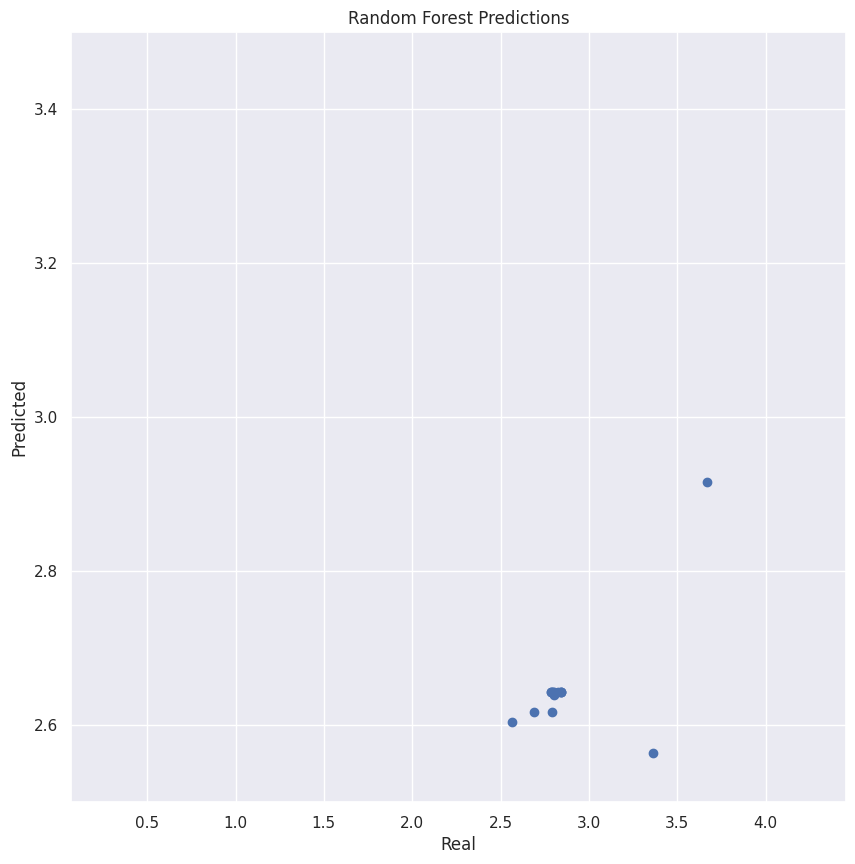

In [61]:
plt.figure(figsize=(10,10))
plt.title('Random Forest Predictions')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.scatter(test_y, y_pred_random_forest)
plt.ylim((2.5,3.5))

(2.5, 4.5)

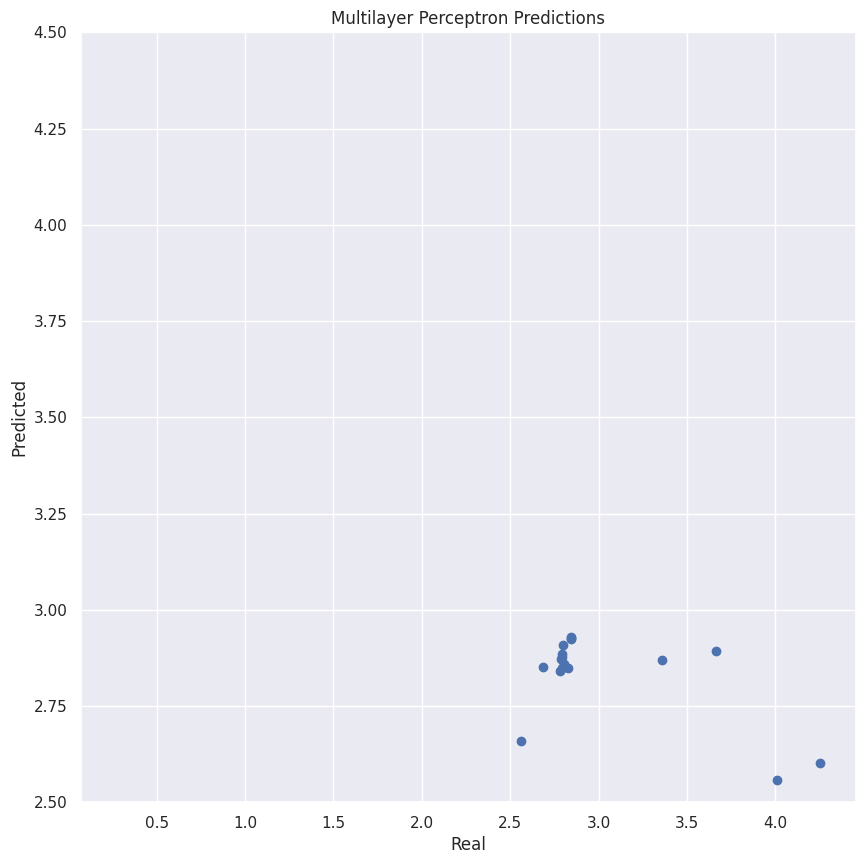

In [62]:
plt.figure(figsize=(10,10))
plt.title('Multilayer Perceptron Predictions')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.scatter(test_y, y_pred_mlp)
plt.ylim((2.5,4.5))

(2.5, 3.5)

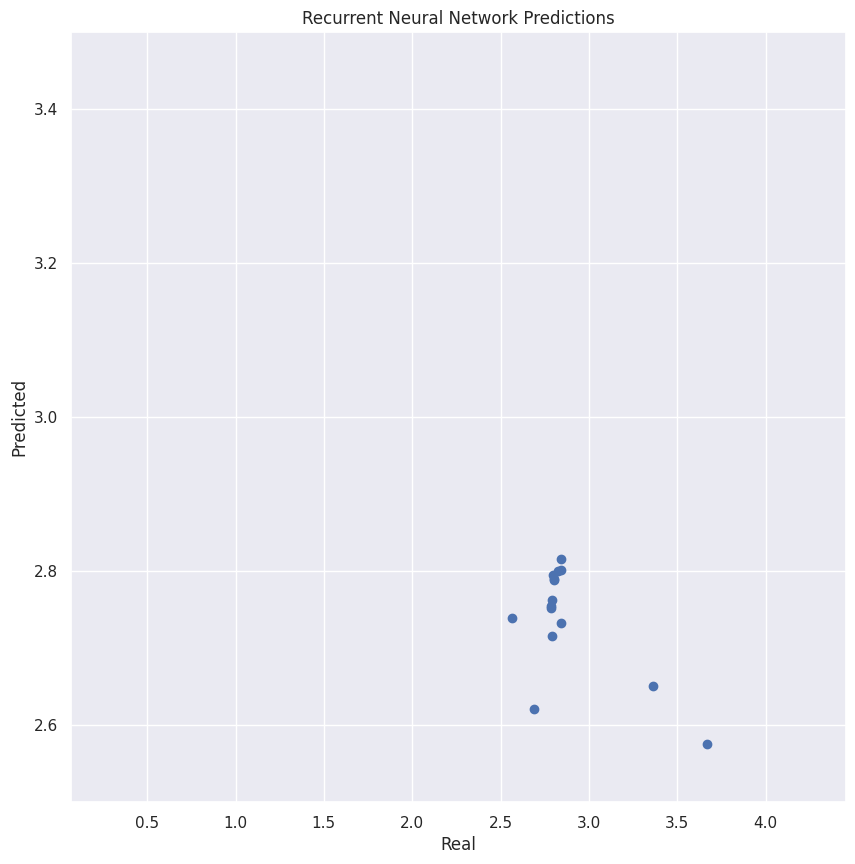

In [65]:
plt.figure(figsize=(10,10))
plt.title('Recurrent Neural Network Predictions')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.scatter(test_y, y_pred_rnn)
plt.ylim((2.5,3.5))

In [79]:
hidden_rnn

tensor([[[-0.9994,  0.9862, -0.1857,  0.6485,  0.9990, -0.9935, -0.9996,
          -0.9999, -0.9853,  0.9658,  0.9987, -0.9996]]])

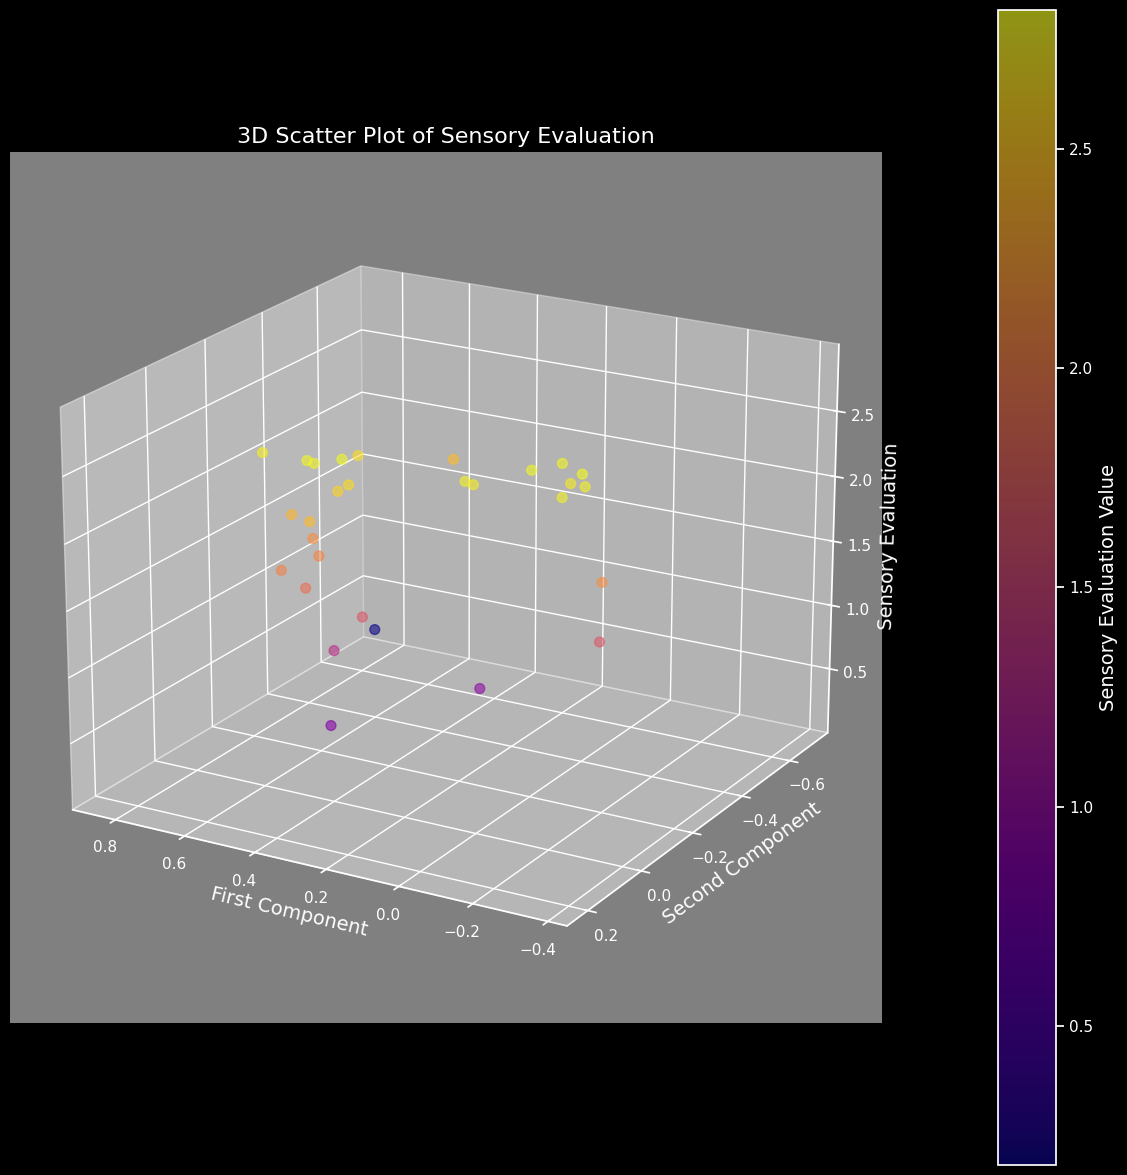

In [91]:
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('dark_background')
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d', facecolor='gray')
scatter = ax.scatter(train_X[:29, 0], train_X[:29, 1], y_pred_rnn, c=y_pred_rnn, cmap='plasma', s=50, alpha=0.6)
ax.set_xlabel('First Component', fontsize=14, color='white')
ax.set_ylabel('Second Component', fontsize=14, color='white')
ax.set_zlabel('Sensory Evaluation', fontsize=14, color='white')
ax.set_title('3D Scatter Plot of Sensory Evaluation', fontsize=16, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')
ax.view_init(elev=20, azim=120)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Sensory Evaluation Value', fontsize=14, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
plt.show()


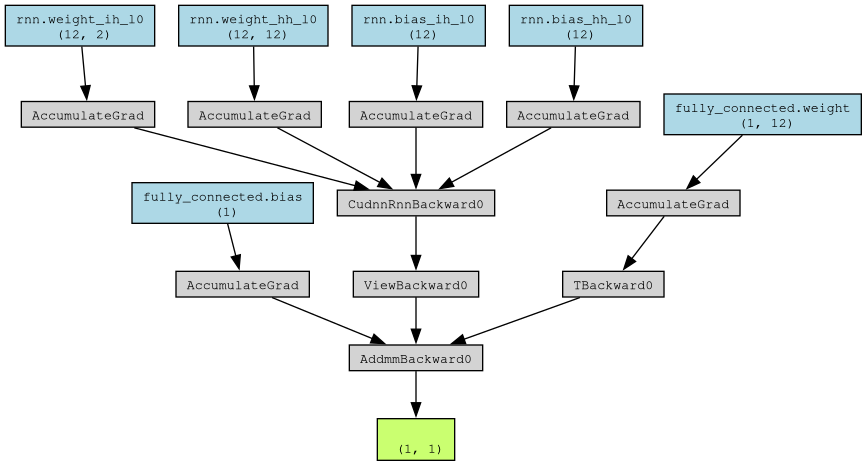

In [56]:
from torchviz import make_dot

# Set model to evaluation mode and set it to current device
Model_RNN.eval().to(device)

# Create a dummy input tensor that matches the model's expected input dimensions
dummy_input = torch.randn(1, 1, 2).to(device) 

# Perform a forward pass through the model with dummy input to get the output
output, _ = Model_RNN(dummy_input.to(device))

# Generate the visualization using the output tensor
dot = make_dot(output, params=dict(Model_RNN.named_parameters()))

# Render and save the visualization to a file
dot.render("RNNModelVisualization", format="png")

from IPython.display import Image

Image('RNNModelVisualization.png')

# Export model

This model will be deployed in Python via a REST API with Flask. The Flask web app will then be deployed to a Linux web server using Unicorn.

In [ ]:
def save_models():
    torch.save(Model_Random_Forest, 'rf.pickle')
    torch.save(Model_MLP, 'mlp.pickle')
    torch.save(Model_RNN, 'rnn.pickle')

save_models()
